In [ ]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [1]:
import numpy as np
import pandas as pd
from quetzal.model import stepmodel
import matplotlib.pyplot as plt

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Logit model step
## Needs LoS tables and calibration parameters
## Saves logit probabilities and utilities

In [2]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_los')
car = stepmodel.read_json(model_path + 'de_road_los')

In [4]:
# DEPRECTED: In the calibration, accessibility applies only to PT
#car.car_los['accessibility'] = 0
#sm.pt_los.loc[sm.pt_los['route_type']=='walk', 'accessibility'] = 0

In [5]:
# Scale time to hours
if sm.pt_los['time'].mean() > 3600:
    sm.pt_los['time'] = sm.pt_los['time'] / 3600
elif sm.pt_los['time'].mean() < 10/3600:
    sm.pt_los['time'] = sm.pt_los['time'] * 3600
sm.pt_los['time'].mean()

5.837568290692537

In [6]:
if car.car_los['time'].mean() > 3600:
    car.car_los['time'] = car.car_los['time'] / 3600
car.car_los['time'].mean()

4.511859399226023

In [7]:
sm.pt_los.sample()

,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,mode_utility,ntransfers,origin,...,"('Fz1', 'utility')","('Fz2', 'utility')","('Fz3', 'utility')","('Fz4', 'utility')","('Fz6', 'utility')","('Fz1', 'probability')","('Fz2', 'probability')","('Fz3', 'probability')","('Fz4', 'probability')","('Fz6', 'probability')"
index,,,,,,,,,,,,,,,,,,,,,
593755,1305.0,NaN,DE272,418.0,16560.0,444596,"[r_s_52543, r_s_52544, r_s_52545, r_s_52546, r...",-2.430772,2,DEC02,...,-6.226615,-3.443739,-7.450912,-5.105162,-5.268658,0.091964,0.244748,0.033018,0.062296,0.060037


In [8]:
# Create LoS table
sm.los = pd.concat([sm.pt_los, car.car_los])
sm.los.reset_index(drop=True, inplace=True)
len(sm.los)

880376

In [9]:
sm.los.drop([col for col in sm.los.columns if col.startswith('(')],
            axis=1, inplace=True, errors='ignore')

In [10]:
# Clean LoS table
sm.los = sm.los.loc[sm.los['time']>0]
sm.los = sm.los.loc[sm.los['length']<=1000000]
len(sm.los)

880376

In [11]:
# Make route types hashable
sm.los['route_types'] = sm.los['route_types'].apply(tuple)

In [12]:
# Add a rail connection that had been missing in cal11
if len(sm.los.loc[(sm.los['origin']=='DEA24') &
                  (sm.los['destination']=='DEA23') &
                  (sm.los['route_type']=='rail_short')]) == 0:
    sm.los = sm.los.append(pd.DataFrame(data=
        {'origin': ['DEA24', 'DEA23'], 'destination': ['DEA23', 'DEA24'],
         'time': [50.875/60, 50.875/60], 'length': [20000, 20000], 'price': [5, 5],
         'route_types': [('rail_short',), ('rail_short',)],
         'route_type':['rail_short', 'rail_short'], 'ntransfers': [0,0],
         'link_path': [[], []]}
    )).reset_index(drop=True)

## Prepare the logit model

Load parameters and generate LoS columns

In [13]:
# Define route types for the choice tree
route_types = ['rail',#'rail_long', 'rail_short',
               'bus',#'coach', 'bus',
               'air','car', 'walk']

In [14]:
# Aggregate route types rail and road PT
type_dict = {'rail_long': 'rail', 'rail_short': 'rail', 'rail': 'rail',
             'coach': 'bus', 'bus': 'bus',
             'air': 'air', 'car': 'car', 'walk': 'walk'}
assert set(route_types).issubset(set(type_dict.keys()))
if not 'route_type_disagg' in sm.los.columns:
    sm.los['route_type_disagg'] = sm.los['route_type'].copy()
sm.los['route_type'] = sm.los['route_type'].map(type_dict)

In [1]:
# Transport demand segments: the cartesian product of
# trip purposes and car ownership
segments = [('Fz'+str(p), car) for p in [1,2,3,4,6] for car in [0,1]]

In [16]:
# Create a column for generalised cost, see cal20
vot = pd.read_csv(input_path + 'vot.csv', header=[0,1], index_col=0).to_dict()
m_dict = {'rail_long': 'PT', 'rail_short': 'PT', 'rail': 'PT',
          'coach': 'PT', 'bus': 'PT', 'air': 'air', 'car': 'car'}
'''# Take averages over distances
vot = {('Fz1', 'PT'): 4.47, ('Fz1', 'air'): 33.67, ('Fz1', 'car'): 4.87,
       ('Fz2', 'PT'): 4.39, ('Fz2', 'air'): 33.67, ('Fz2', 'car'): 3.9,
       ('Fz3', 'PT'): 5.11, ('Fz3', 'air'): 33.67, ('Fz3', 'car'): 4.29,
       ('Fz4', 'PT'): 7.01, ('Fz4', 'air'): 38.76, ('Fz4', 'car'): 8.5,
       ('Fz6', 'PT'): 4.35, ('Fz6', 'air'): 25.45, ('Fz6', 'car'): 4.35}'''
'''# Take the same VoT for every segment
sm.los['gc'] = sm.los['time'] + [c / vot['root', m_dict[m]][int(d/1000)]
    if m!='walk' else 0 for c,d,m in zip(sm.los['price'], sm.los['length'], sm.los['route_type'])]
'''
# Take segment-specific VoT
for s in segments:
    sm.los[(s, 'gc')] = sm.los['time'] + [c / vot[s, 'all'][int(d/1000)] # m_dict[m] for mode-specific instead of all
        if m!='walk' else 0 for c,d,m in zip(
            sm.los['price'], sm.los['length'], sm.los['route_type'])]

In [17]:
# Load estimation results
excel = pd.ExcelFile(input_path + 'estimation_results.xls')
params_est = []
for segment in range(2, len(segments)+2): # First two sheets are all purposes
    df = excel.parse(segment)
    params_est.append(df.set_index(df.columns[0]))

In [18]:
# The nested logit structure can be set for each segment
# It must be the same as in the estimation
segs = segments + ['root']
col = ['root']*len(route_types) + [np.nan] #['pt']*(len(route_types)-3) + ['root']*4 + [np.nan]
nests = pd.DataFrame(index=route_types+['root'], #['pt', 'root'],
                     data={s: col for s in segments})
nests.index.name = 'route_type'
nests.columns.name = 'segment'
sm.mode_nests = nests
sm.mode_nests

segment,Fz1,Fz2,Fz3,Fz4,Fz6
route_type,,,,,
rail,root,root,root,root,root
bus,root,root,root,root,root
air,root,root,root,root,root
car,root,root,root,root,root
walk,root,root,root,root,root
root,NaN,NaN,NaN,NaN,NaN


In [19]:
# phi/theta values for each mode and nest come from calibration data
sm.logit_scales = pd.DataFrame(index=route_types, data={seg: 1 for seg in segs})
# For the nested structure
#sm.logit_scales.loc['pt'] = [1 / params_est[i].loc['mu_pt', 'Value']
#                             for i in range(len(segments))]
sm.logit_scales

,Fz1,Fz2,Fz3,Fz4,Fz6
rail,1,1,1,1,1
bus,1,1,1,1,1
air,1,1,1,1,1
car,1,1,1,1,1
walk,1,1,1,1,1
root,1,1,1,1,1


In [20]:
# Initial values are the alternative specific constants (ASC) from calibration
sm.mode_utility = pd.DataFrame({seg: [] for seg in segments})
for t, asc in [('rail', 0),
#               ('rail_short', 'asc_rail_s'),
#               ('rail_long', 'asc_rail_l'),
#               ('coach', 'asc_coach'),
               ('bus', 'asc_road'),
               ('air', 'asc_air'), ('car', 'asc_car'),
               ('walk', 'asc_non_motor'),('root', 0)]:
    sm.mode_utility.loc[t] = [params_est[i].loc[asc, 'Value']
                              if isinstance(asc, str) else asc
                              for i in range(len(segments))]
sm.mode_utility

,Fz1,Fz2,Fz3,Fz4,Fz6
rail,-1.808226,-0.443240,-2.912522,-2.398797,-2.437387
bus,-3.142596,-0.390276,-3.469490,-3.743019,-3.321016
air,-10.328589,-10.375502,-8.273385,-4.623388,-6.129203
car,0.000000,0.000000,0.000000,0.000000,0.000000
walk,-5.291728,-2.789105,-4.471586,-4.651219,-3.904938
root,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
# Performance attributes for mode choice
#perf_attrs = ['gc_d']#, 'accessibility']
perf_attrs = [(s, 'gc_d') for s in segments]

In [22]:
# Beta parameters from calibration data
# IMPORTANT: watch the conversion
sm.utility_values = pd.DataFrame({seg: [0]*len(perf_attrs)
                                  for seg in segments}, index=perf_attrs)
sm.utility_values.loc['mode_utility'] = [1 for seg in segments]
for a,s in zip(perf_attrs, segments):
    sm.utility_values.loc[a, s] = params_est[segments.index(s)].loc['b_gc', 'Value']
sm.utility_values

,Fz1,Fz2,Fz3,Fz4,Fz6
"(Fz1, gc_d)",-0.485613,0.000000,0.000000,0.000000,0.000000
"(Fz2, gc_d)",0.000000,-0.245779,0.000000,0.000000,0.000000
"(Fz3, gc_d)",0.000000,0.000000,-0.431662,0.000000,0.000000
"(Fz4, gc_d)",0.000000,0.000000,0.000000,-0.322041,0.000000
"(Fz6, gc_d)",0.000000,0.000000,0.000000,0.000000,-0.284947
mode_utility,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
# Generate damped cost
def spline(x, beta=1, Q=3, c0=0, c1=20, c2=40, c3=np.inf):
    c = [c0,c1,c2,c3]
    alpha = [0, -beta/2*np.power(np.log(c1),3),
             -beta/2*np.log(c1)*(3*np.power(np.log(c2),2)+np.power(np.log(c1),2))] # for Q=3
    theta = [1, 3/2*np.log(c1), 3*np.log(c1)*np.log(c2)] # for Q=3
    def component(x, q):
        return beta*theta[q-1]*np.power(np.log(x),Q-q+1) + alpha[q-1]
    return sum([component(x, q) if x>=c[q-1] and x<c[q] else 0 for q in range(1,Q+1)])
for a, s in zip(perf_attrs, segments):
    sm.los[a] = sm.los[(s, 'gc')].apply(spline)
#sm.los['gc_d'] = sm.los['gc'].apply(spline)

In [24]:
# Show the performance attributes
sm.los.sample(5).sort_values('length').set_index(
    ['origin', 'destination', 'route_type'])[perf_attrs+['length']]

,,,"(Fz1, gc_d)","(Fz2, gc_d)","(Fz3, gc_d)","(Fz4, gc_d)","(Fz6, gc_d)",length
origin,destination,route_type,,,,,,
DE715,DEB3I,bus,0.985447,1.180729,0.871554,0.876111,1.030206,25931
DEC05,DE26A,bus,7.250061,8.427428,7.728979,6.978838,7.681354,289642
DE146,DE26A,rail,4.224508,5.523850,4.771405,3.933472,4.680024,318080
DE94H,DE725,rail,11.044911,14.381109,12.582386,10.271628,12.152294,396477
DE21G,DEA42,air,14.271101,23.252478,19.584886,12.016775,16.417294,725614


<AxesSubplot:xlabel='length'>

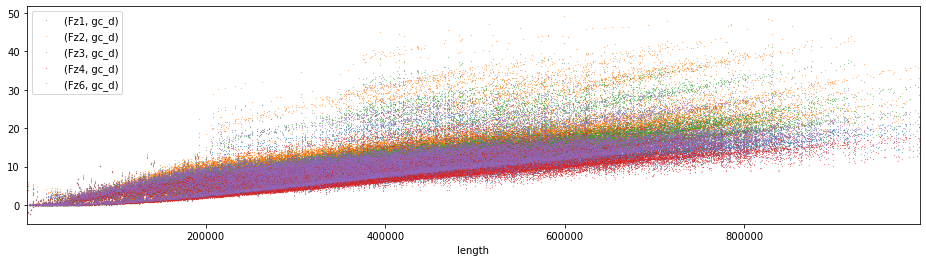

In [25]:
if manual:
    sm.los.set_index('length')[perf_attrs].sample(int(len(sm.los)/20)).plot(
        subplots=False, figsize=(16,4), linestyle=' ', marker='x', markersize=.6, alpha=.5)

## Mode Choice

In [26]:
# Build the utility column in sm.los for each segment
sm.segments = segments
# How defines the mode which ASC is taken: "min" is worst mode in route_types,
# "max" is best, "sum" and "mean"
# Set the main mode as route types to take only this ASC
#sm.los['route_types'] = [(i,) for i in sm.los['route_type']]
sm.analysis_mode_utility(how='main', segment=None)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


In [27]:
# Run the logit model to calculate probabilities
sm.step_logit()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.82it/s]


In [28]:
print(sm.probabilities.shape)
print(sm.utilities.shape)

(801995, 9)
(801995, 9)


In [29]:
sm.probabilities.sample(n=5)

route_type,origin,destination,segment,root,walk,car,air,bus,rail
7932,DE126,DEG0B,Fz3,1,0.0,0.960999,0.000000e+00,0.012809,0.026192
72814,DEE08,DE711,Fz6,1,0.0,0.919804,0.000000e+00,0.040864,0.039332
32007,DE71B,DE112,Fz3,1,0.0,0.955262,0.000000e+00,0.003513,0.041225
42292,DE736,DE21F,Fz3,1,0.0,0.839354,5.992174e-07,0.001838,0.158807
66271,DEB3I,DE21B,Fz2,1,0.0,0.568042,1.775691e-07,0.122074,0.309884


In [30]:
sm.utilities.sample(n=5)

route_type,origin,destination,segment,root,walk,car,air,bus,rail
18068,DE215,DE121,Fz4,-2.312668,-inf,-2.370698,-inf,-inf,-5.188342
63828,DEB38,DEF04,Fz4,-3.245428,-inf,-3.590580,-7.610183,-inf,-4.521365
1471,DE113,DEB12,Fz2,-1.537142,-inf,-1.882102,-17.665988,-4.501143,-2.963677
56105,DEA5C,DE129,Fz1,-2.981906,-inf,-3.154283,-inf,-7.686324,-4.883816
22908,DE243,DE732,Fz4,-0.302953,-inf,-0.431781,-inf,-4.873418,-2.505497


In [31]:
sm.los.sample()

,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,mode_utility,ntransfers,origin,...,"(Fz1, utility)","(Fz2, utility)","(Fz3, utility)","(Fz4, utility)","(Fz6, utility)","(Fz1, probability)","(Fz2, probability)","(Fz3, probability)","(Fz4, probability)","(Fz6, probability)"
420134,2166.0,NaN,DE94B,427.0,5760.0,183870,"[bus_2774006, bus_2774007, r_s_114548, r_s_114...",-2.437387,3,DE94G,...,-5.345342,-2.826604,-6.353233,-4.541648,-4.82418,0.012489,0.080413,0.004488,0.018608,0.015165


## Save model

In [32]:
sm.utilities.reset_index(drop=True, inplace=True)
sm.probabilities.reset_index(drop=True, inplace=True)
sm.to_json(model_path + 'de_logit', only_attributes=[
    'segments', 'mode_nests', 'logit_scales', 'mode_utility',
    'utility_values', 'probabilities', 'utilities'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 38/38 [00:09<00:00,  3.84it/s]


In [33]:
# Save LoS table
sm.pt_los = sm.los.loc[sm.los['route_type']!='car']
sm.to_json(model_path + 'de_pt_los', only_attributes=['pt_los'],
           encoding='utf-8')
sm.car_los = sm.los.loc[sm.los['route_type']=='car']
sm.to_json(model_path + 'de_road_los', only_attributes=['car_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 39/39 [00:18<00:00,  2.10it/s]


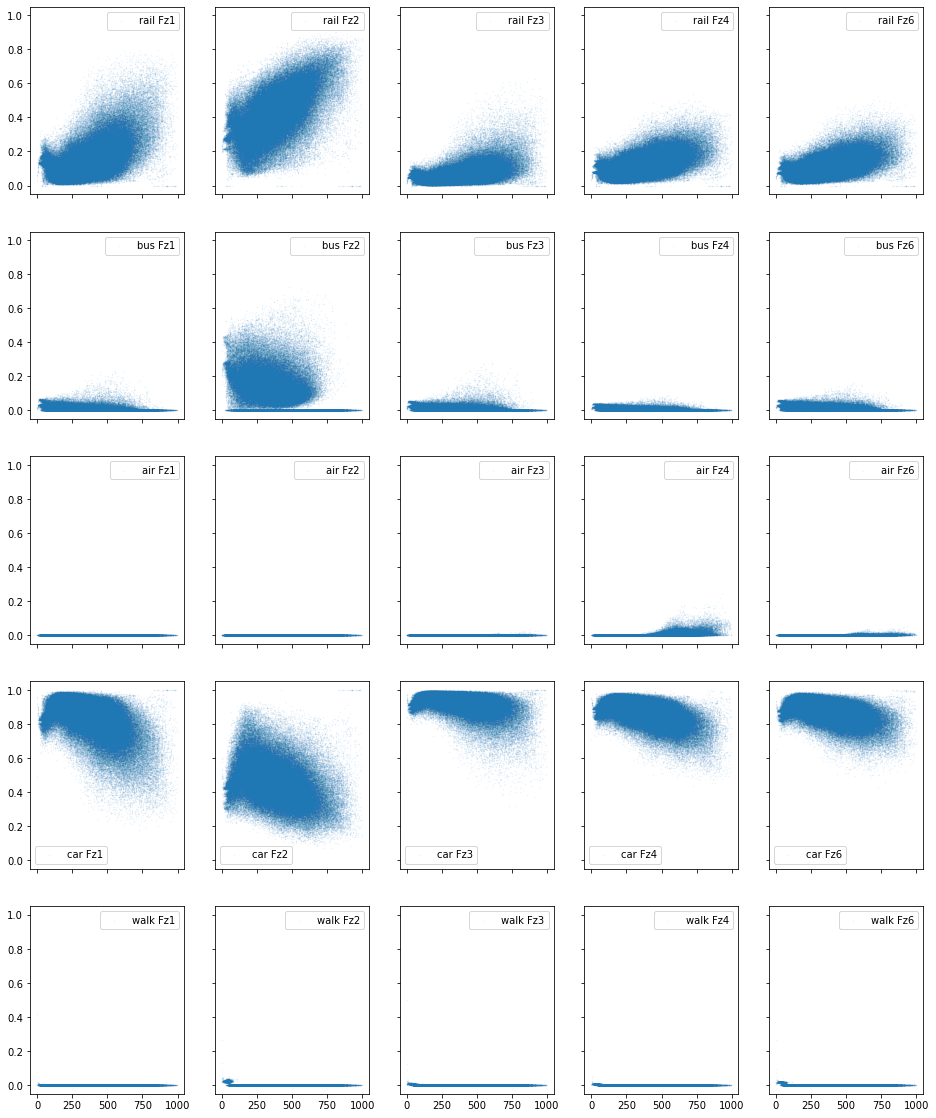

In [34]:
# Distance-distribution of probabilities
if manual:
    merged = sm.probabilities.merge(car.car_los[['origin', 'destination', 'length']],
                                    on=['origin', 'destination'], how='inner')
    fig, ax = plt.subplots(nrows=len(segments), ncols=len(route_types),
                           sharex='all', sharey='all', figsize=(16,len(segments)*3))
    for j, mode in zip(range(len(route_types)), route_types):
        for i, seg in zip(range(len(segments)), segments):
            x = merged.loc[merged['segment']==seg, 'length'] / 1000
            y = merged.loc[merged['segment']==seg, mode]
            ax[i,j].scatter(x, y, marker='o', s=.15, alpha=.1, label=mode+' '+seg)
            #p = np.poly1d(np.polyfit(x, y, deg=3))
            #ax[i,j].plot(x, p(x), linestyle='', marker='o', markersize=.5, color='grey', label=mode+' '+seg)
            ax[i,j].legend()